<a href="https://colab.research.google.com/github/sandeeps2004/JPM-QuantResearch-Virtual-Task-2/blob/main/price_commodity_storage_contract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

def price_storage_contract(
    injection_dates,
    withdrawal_dates,
    price_data,
    injection_rate,
    withdrawal_rate,
    max_storage,
    storage_cost_per_month,
    injection_cost,
    withdrawal_cost,
    transport_cost
):


    total_injected = 0
    total_withdrawn = 0
    cash_flow = 0
    detailed_log = []

    # Convert price dates to datetime
    price_data["Date"] = pd.to_datetime(price_data["Date"])

    # Handle injections (buy phase)
    for date in injection_dates:
        date = pd.to_datetime(date)
        price_row = price_data.loc[price_data["Date"] == date]
        if price_row.empty:
            raise ValueError(f"No price data found for injection date {date.date()}")

        price = price_row["Price"].values[0]
        volume = min(injection_rate, max_storage - total_injected)
        total_injected += volume
        cost = volume * price + injection_cost + transport_cost
        cash_flow -= cost  # outflow

        detailed_log.append({
            "Type": "Injection",
            "Date": date,
            "Price": price,
            "Volume": volume,
            "CashFlow": -cost
        })

    # Handle withdrawals (sell phase)
    for date in withdrawal_dates:
        date = pd.to_datetime(date)
        price_row = price_data.loc[price_data["Date"] == date]
        if price_row.empty:
            raise ValueError(f"No price data found for withdrawal date {date.date()}")

        price = price_row["Price"].values[0]
        volume = min(withdrawal_rate, total_injected - total_withdrawn)
        total_withdrawn += volume
        revenue = volume * price - withdrawal_cost - transport_cost
        cash_flow += revenue  # inflow

        detailed_log.append({
            "Type": "Withdrawal",
            "Date": date,
            "Price": price,
            "Volume": volume,
            "CashFlow": revenue
        })

    # Calculate storage cost for total months used
    total_months = len(pd.date_range(injection_dates[0], withdrawal_dates[-1], freq="M"))
    total_storage_cost = storage_cost_per_month * total_months
    cash_flow -= total_storage_cost

    detailed_log.append({
        "Type": "Storage",
        "Date": f"{total_months} months",
        "Price": None,
        "Volume": None,
        "CashFlow": -total_storage_cost
    })

    total_value = cash_flow
    summary = {
        "Total Injected": total_injected,
        "Total Withdrawn": total_withdrawn,
        "Total Storage Months": total_months,
        "Storage Cost": total_storage_cost,
        "Final Contract Value ($)": total_value
    }

    return total_value, pd.DataFrame(detailed_log), summary

if __name__ == "__main__":

    # Sample natural gas price data
    data = {
        "Date": ["2025-05-01", "2025-06-01", "2025-07-01", "2025-11-01", "2025-12-01"],
        "Price": [2.0, 2.1, 2.3, 3.0, 3.2]
    }
    price_data = pd.DataFrame(data)

    # Define contract parameters
    injection_dates = ["2025-05-01", "2025-06-01"]
    withdrawal_dates = ["2025-11-01", "2025-12-01"]

    contract_value, log_df, summary = price_storage_contract(
        injection_dates=injection_dates,
        withdrawal_dates=withdrawal_dates,
        price_data=price_data,
        injection_rate=500000,
        withdrawal_rate=500000,
        max_storage=1000000,
        storage_cost_per_month=100000,
        injection_cost=10000,
        withdrawal_cost=10000,
        transport_cost=50000
    )

    print("\n=== Contract Summary ===")
    for key, val in summary.items():
        print(f"{key}: {val}")

    print("\n=== Transaction Log ===")
    print(log_df)



=== Contract Summary ===
Total Injected: 1000000
Total Withdrawn: 1000000
Total Storage Months: 7
Storage Cost: 700000
Final Contract Value ($): 110000.0

=== Transaction Log ===
         Type                 Date  Price    Volume   CashFlow
0   Injection  2025-05-01 00:00:00    2.0  500000.0 -1060000.0
1   Injection  2025-06-01 00:00:00    2.1  500000.0 -1110000.0
2  Withdrawal  2025-11-01 00:00:00    3.0  500000.0  1440000.0
3  Withdrawal  2025-12-01 00:00:00    3.2  500000.0  1540000.0
4     Storage             7 months    NaN       NaN  -700000.0


/tmp/ipython-input-1291222279.py:69: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  total_months = len(pd.date_range(injection_dates[0], withdrawal_dates[-1], freq="M"))


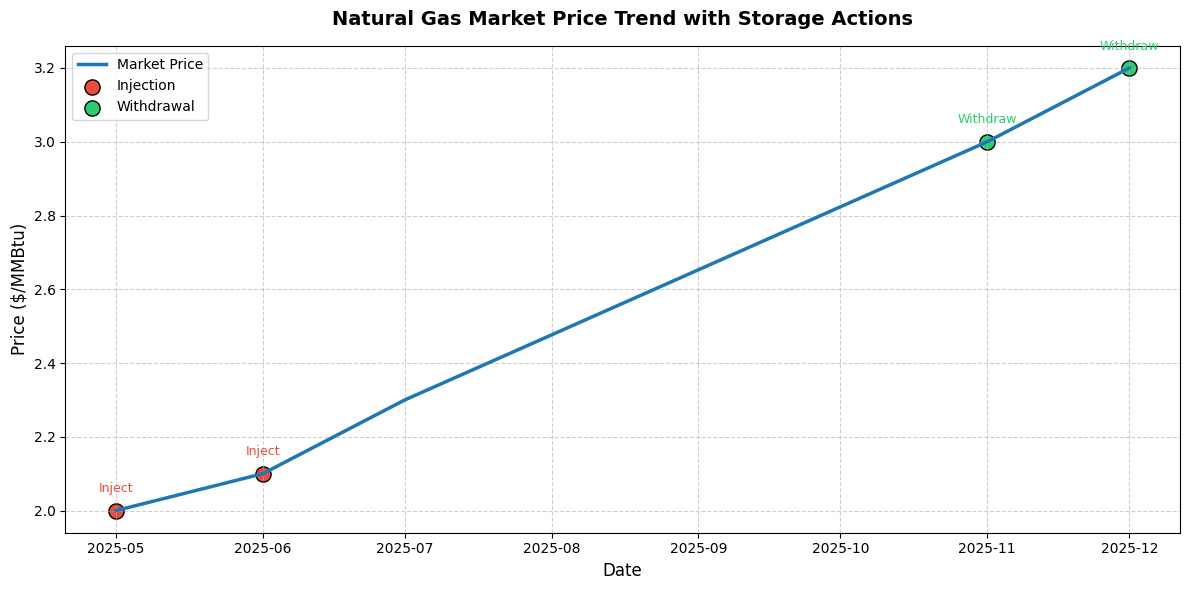

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(price_data["Date"], price_data["Price"], color="#1f77b4", linewidth=2.5, label="Market Price")

# Mark Injection Points
for date in injection_dates:
    d = pd.to_datetime(date)
    price = price_data.loc[price_data["Date"] == d, "Price"].values[0]
    plt.scatter(d, price, color="#E74C3C", s=120, edgecolors="black", label="Injection" if date == injection_dates[0] else "")
    plt.text(d, price + 0.05, "Inject", ha="center", fontsize=9, color="#E74C3C")

# Mark Withdrawal Points
for date in withdrawal_dates:
    d = pd.to_datetime(date)
    price = price_data.loc[price_data["Date"] == d, "Price"].values[0]
    plt.scatter(d, price, color="#2ECC71", s=120, edgecolors="black", label="Withdrawal" if date == withdrawal_dates[0] else "")
    plt.text(d, price + 0.05, "Withdraw", ha="center", fontsize=9, color="#2ECC71")

plt.title("Natural Gas Market Price Trend with Storage Actions", fontsize=14, fontweight="bold", pad=15)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price ($/MMBtu)", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()